In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from beeid2.models import simple_cnnv2, ContrastiveLearning
from beeid2.data_utils import filename2image
from beeid2.evaluation import mAP_evaluation, mAP_track_model_evaluation, cmc_track_model_evaluation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from tqdm import tqdm
import glob
from skimage import io
from beeid2.evaluation import get_query_galleries, plot_query_gallery

def to_np_array(values, dim=128):
    return np.concatenate(list(values)).reshape(-1, dim)


EVALUATION_FILES = {
    "test": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_unnormalized.csv",
    "valid_with_shared_ids_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/valid_with_shared_ids_unnormalized.csv",
    "valid_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/valid_galleries_unnormalized.csv",
    "test_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_galleries_unnormalized.csv",
    "test_no_train_overlap_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_no_train_overlap_unnormalized.csv",
    "test_same_hour_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_same_hour2_unnormalized.csv",
    "test_same_hour_diff_day_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day_same_hour2_unnormalized.csv",
    "test_diff_day_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day2_unnormalized.csv",
    "track_test_same_hour": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_same_hour3_unnormalized.csv",
    "track_test_same_hour_diff_day": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day_same_hour3_unnormalized.csv",
    "track_test_diff_day": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day3_unnormalized.csv",

}



In [3]:
MODEL = "../../models2/2111241016_tagged_untagged_simplecnnv2_convb3_dim_128/model.tf"

In [4]:
base_model = load_model(MODEL)

In [5]:
queryG = get_query_galleries(base_model)

13/13 [==============================] - 1s 95ms/step


100%|██████████| 654/654 [00:02<00:00, 243.29it/s]


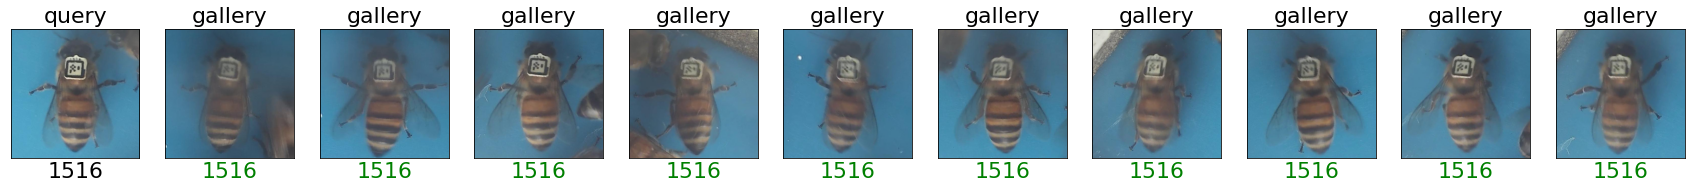

In [8]:
plot_query_gallery(queryG[110])

In [29]:
TRACK_LEN=4
# base_model = load_model(MODEL)
track_model = tf.keras.Sequential()
track_model.add(tf.keras.layers.TimeDistributed(base_model, input_shape=(TRACK_LEN, 56, 56, 3)))
track_model.add(tf.keras.layers.Lambda(lambda x: tf.math.reduce_mean(x, axis=1)))
track_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 4, 128)            1815040   
_________________________________________________________________
lambda_3 (Lambda)            (None, 128)               0         
Total params: 1,815,040
Trainable params: 1,814,336
Non-trainable params: 704
_________________________________________________________________


In [30]:
queryG = get_query_galleries_tracks(track_model, track_len=4, timegap=15, timegap_unit="m", batch_size=64)

4/4 [==============================] - 0s 93ms/step
Evaluating 228 tracks.


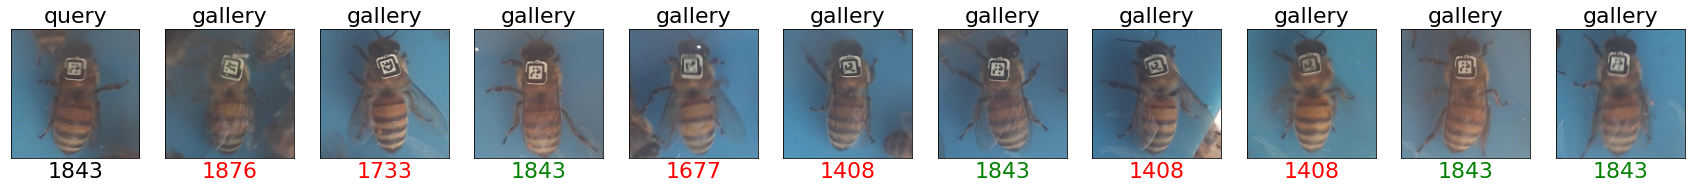

In [41]:
plot_query_gallery_track(queryG[10])

In [9]:
queryG[0][0]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,track_id,frame,angle,x,y,parts_num,tag_id,...,B_mean,abdomen_angle,H_mean,S_mean,V_mean,datetime2,days,global_track_id,day_int,emb
0,24516,24516,225622,16760,28543,205.866357,1912,808,4,1183.0,...,108,304.380345,0.387951,0.266357,0.46383,2019-08-01 08:23:47.150,2019-08-01,154_02_R_190801080000_16760,1,"[0.019305386, 0.022719633, 0.18451692, 0.10811..."
